<div style="border:solid green 5px; padding: 20px"> 

<font size="5"> Проект: Выбор локации для скважины

<font size="5"><b>Описание проекта

Сотрудникам добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:

В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;

Строят модель для предсказания объёма запасов в новых скважинах;

Выбирают скважины с самыми высокими оценками значений;

Определяют регион с максимальной суммарной прибылью отобранных скважин.

В исходных данных предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

<font size="5"><b>Условия задачи

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

<font size="5"><b>Задачи проекта

- **первая задача** - Постройте модель для определения региона, где добыча принесёт наибольшую прибыль.






- **вторая задача** — Проанализируйте возможную прибыль и риски техникой Bootstrap.

<font size="5"><strong>Исходные данные.</strong></p>


<p class="p1">Данные геологоразведки трёх регионов находятся в 3 файлах</p>
<ul class="ul1">
    <li class="li1"><span class="s1"></span>id — уникальный идентификатор скважины;</li>
    <li class="li1"><span class="s1"></span>f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);</li>
    <li class="li1"><span class="s1"></span>product — объём запасов в скважине (тыс. баррелей).</li>
</ul>

<font size="5"><b>План работы </b>


<ol class="ol1">
    <li class="li1">Загрузка данных</li>
    <li class="li1">Предобработка данных</li>
    <li class="li1">Исследовательский анализ данных</li>  
    <li class="li1">Корреляционный анализ</li>
    <li class="li1">Подготовка данных</li>
    <li class="li1">Обучение и проверка модели</li>
    <li class="li1">Рассчет прибыли и рисков</li>
    <li class="li1">Вывод</li>
</ol>


### Импорты

#### Импорты библиотек 

In [1]:
!pip install -Uq scikit-learn
!pip install phik -q

In [2]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import os
import phik
# import shap

from phik.report import plot_correlation_matrix
from IPython.display import Markdown, display
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# библиотеки для статистики
from scipy import stats as st
from scipy.stats import shapiro


# бибилотеки для подготовки данных
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     RandomizedSearchCV, cross_val_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             r2_score, make_scorer, 
                             mean_squared_error, root_mean_squared_error)

#### Константы и цветовые настройки

In [3]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette('deep')

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### Импорт данных

In [5]:
local_data_path = '/Users/malkovkonstantin/Desktop/DS/Jupiter'

files = {
    'region_0': 'geo_data_0.csv',
    'region_1': 'geo_data_1.csv',
    'region_2': 'geo_data_2.csv'
}

dfs = {} 

for name, filename in files.items():
    file_path = os.path.join(local_data_path, filename)
    if os.path.exists(file_path):
        dfs[name] = pd.read_csv(file_path)
    else:
        url = f'https://code.s3.yandex.net/datasets/{filename}'
        dfs[name] = pd.read_csv(url)

for name, df in dfs.items():
    df.name = name
        
for name, df in dfs.items():
    globals()[name] = df

#### Функции

In [6]:
def first_view(df):
    '''Функция для первого знакомства с датасетом:
    10 случайных строк, Информация о датафрейме, 
    Описательная статистика, Количество пропусков, Количество явных дубликатов,
    Колличество строк и столбцов, Название столбцов
    '''
    df.columns = df.columns.str.lower()
    print(f"10 случайных строк:\n{df.sample(10)}\n{'-' * 100}")
    print("Информация о датафрейме:\n")
    print(df.info(), "\n" + '-' * 100)
    print("Количество пропусков:\n")
    print(df.isna().sum(), "\n" + '-' * 100)
    print(f"- Количество явных дубликатов: {df.duplicated().sum()}")
    print(f"- Колличество строк и столбцов: {df.shape}")
    print(f"- Название столбцов: {df.columns}")

In [7]:
def heading_violet(text):
    '''Функция принимает текст и выделяет его цветом'''
    display(Markdown(f'<span style="color:MediumVioletRed;"><strong>{text}</span>') )

In [8]:
def num_cat_split(df):
    '''Функция принимает DF и разделяет на numeric/category columns'''
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    category_columns = df.select_dtypes(include=['object', 'category']).columns
    return numeric_columns, category_columns

In [9]:
def plot_h_bp(dataframe, numeric_columns, bins):
    '''Функция строит графики распределения количественных признаков (гистограмму и боксплот)
    dataframe - DataFrame с данными
    numeric_columns - список с названиями количественных признаков
    bins - количество корзин для гистограммы'''
    fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(16, 5*len(numeric_columns)))    

    for idx, column in enumerate(numeric_columns):
        sns.histplot(dataframe[column], bins=bins, ax=axes[idx, 0], kde=True)
        axes[idx, 0].set_title(f'Гистограмма распределения для {column}', 
                               fontweight='bold', fontsize=14)
        axes[idx, 0].set_ylabel('Частота')
        axes[idx, 0].axvline(dataframe[column].mean(), color='red',linestyle = ':', label='Среднее')
        axes[idx, 0].axvline(dataframe[column].median(), color='purple', linestyle = '--', label='Медиана')
        axes[idx, 0].legend()
       

        sns.boxplot(x=dataframe[column], ax=axes[idx, 1], flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
        axes[idx, 1].set_title(f'Боксплот для {column}', 
                               fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

In [10]:
def describe_numeric_column(df, column_name):
    '''Функция принимает Df и список numeric_column, печатает median/mean, min, max'''
    for column in column_name:
        median_value = round(df[column].median(), 2)
        mean_value = round(df[column].mean(), 2)
        min_value = round(df[column].min(), 2)
        max_value = round(df[column].max(), 2)

        print(f'\033[1m{column}:\033[0m медиана/среднее= \
{median_value}/{mean_value}, min = {min_value}, max = {max_value}')

In [11]:
def probplot(df, numeric_columns):
    '''Строим ПробПлоты Q Q квантиля-квантиля'''
    plt.figure(figsize=(15, 5))
    for index, column in enumerate(numeric_columns):
        plt.subplot(2, 2, index + 1)
        st.probplot(df[column], dist='norm', plot=plt)
        plt.title(f'Probability Plot {column}')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [12]:
def for_in(dfs, func):
    '''функция цикла принимат DF и функцию'''
    for name, df in dfs.items():
        heading_violet(f'-------- {name} -------')
        func(df, numeric_columns)

In [13]:
def phik_matrix_heatmap(df, numeric_columns):
    '''Считает фи корреляцию и строит хитмап'''
    phik_matrix = phik.phik_matrix(df[numeric_columns], interval_cols=numeric_columns)
    plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='Reds',
                        title = f'Тепловая карта матрицы Phik {df.name}',
                        fontsize_factor=1,
                        figsize=(5, 4)
                       ) 

In [14]:
def vif_calculation(df):
    '''Принимает DF. рассчет коэффицентов VIF'''
    df_copy = df.copy()
    df_copy = add_constant(df_copy)
    vif_values = [variance_inflation_factor(df_copy.values, i) for i in range(df_copy.shape[1])]  
    vif_df = pd.DataFrame({'Feature': df_copy.columns, 'VIF': vif_values}) 
    display(vif_df)

## Загрузка и подготовка данных

###  Загрузка данных

In [15]:
for name in dfs:
    print(name)

region_0
region_1
region_2


In [16]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    first_view(df)

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

10 случайных строк:
          id        f0        f1        f2     product
87935  s2ILe  0.343316 -0.164519  0.534764  106.134210
57728  DhtxT  0.878607  0.180282  4.866314   72.038155
72958  yw3mS -0.141101  1.144297  8.455333  138.686438
46113  K98Tl  0.958183 -0.611238  5.265782  119.767397
80977  alMer  0.646963  1.008444  0.209905   40.160431
83174  93Fe5  0.782790  0.585326  5.884179  121.315217
37164  sf8aQ -0.892667  0.599593  2.338287   49.740017
15319  Y3U7R  1.312128 -0.426670  4.437409  145.614437
8913   7JJ8y  1.700243 -0.066012  3.625643   79.218422
32432  QqmeE  0.108812  0.144797  0.694859   78.801727
----------------------------------------------------------------------------------------------------
Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 n

<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

10 случайных строк:
          id         f0         f1        f2     product
96480  UvisV   8.783405  -0.011641 -0.006422    0.000000
51749  5QWqA   6.261829  -2.434167  5.004976  134.766305
58354  iaKmM   7.750178   5.450665  4.992367  134.766305
53062  jfXKW  -6.799186 -11.205762  1.009034   30.132364
86062  t2FFr  -8.217326  -8.784810 -0.003928    3.179103
5584   DefDW -15.412232   0.170489  4.997069  137.945408
19364  xCQG9  -6.151011  -9.347939  1.000504   30.132364
66689  pETab  -9.018846  -9.160347  4.994207  137.945408
638    h7A4K   6.090034  -7.176340  3.001628   80.859783
97461  Jcn5L  -1.352908  -5.008378  1.999169   57.085625
----------------------------------------------------------------------------------------------------
Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

10 случайных строк:
          id        f0        f1         f2     product
29715  SbDU8 -0.254134 -0.360522  -0.787397   29.796143
51642  AKcbR  0.091150 -1.393330   5.671042   59.786716
42768  MDN97  1.416667  1.275067   4.389577   98.508449
97481  j9S5a -4.624046  1.271567   6.404195  150.161651
15521  LVbU8  0.962389  1.052729   3.769683   28.087177
49789  pKZuR -3.664011  1.475211  -3.032944   90.304059
30658  y2TfM  0.883343 -3.389257   2.982372   81.665299
21501  YoLWR  0.046971  3.468942  10.511958   97.246939
98035  Jzrmj -1.222538  2.919657  10.717254  141.489627
97720  vELVX -0.158282 -2.523535   3.883582   50.041383
----------------------------------------------------------------------------------------------------
Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0    

#### Вывод



- загрузили 3 дата фрэйма
- данные соответствуют описанию
- типы данных соответствуют содержимому
- явных дубликатов нет 
- явных пропусков нет
- в каждом дата фрэйме по 100000 строк и 5 столбцов


### Предопбработка данных


Проверим дубликаты в индификационных номерах id

In [17]:
duplicates_0 = region_0[region_0.duplicated(subset=['id'], keep=False)]
if not duplicates_0.empty:
    print("Обнаружены дубликаты по столбцу 'id':")
    print(duplicates_0)
else:
    print("Дубликаты по столбцу 'id' не найдены.")

Обнаружены дубликаты по столбцу 'id':
          id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
64022  74z30  0.741456  0.459229   5.153109  140.771492
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
89582  bsk

In [18]:
duplicates_1 = region_1[region_1.duplicated(subset=['id'], keep=False)]
if not duplicates_1.empty:
    print("Обнаружены дубликаты по столбцу 'id':")
    print(duplicates_1)
else:
    print("Дубликаты по столбцу 'id' не найдены.")

Обнаружены дубликаты по столбцу 'id':
          id         f0         f1        f2     product
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044


In [19]:
duplicates_2 = region_2[region_2.duplicated(subset=['id'], keep=False)]
if not duplicates_2.empty:
    print("Обнаружены дубликаты по столбцу 'id':")
    print(duplicates_2)
else:
    print("Дубликаты по столбцу 'id' не найдены.")

Обнаружены дубликаты по столбцу 'id':
          id        f0        f1        f2     product
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572


- region_0, имеет 10 дубликатов по id, 
- region_1 и регион_2 имеет по 4 дубликата по id

в нашей задаче думаю все варианты ок: 
- удалить первую группу
- удалить вторую
- удалить обе группы
- оставить обе группы

ни чего с ними делать не будем, допустим что под одним номером id 2 рядом стоящие точки, которым не присвоили доп индекс

Переведем id в индексы

In [20]:
for name, df in dfs.items():
    df.set_index('id', inplace=True)
    heading_violet(f'-------- {name} -------')
    display(df.head())

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Проверим колличество дубликатов без 'id'

In [21]:
for name, df in dfs.items():
    print(f'Колличество дубликатов без "id" в датафрейме {name}:', df.duplicated().sum())

Колличество дубликатов без "id" в датафрейме region_0: 0
Колличество дубликатов без "id" в датафрейме region_1: 0
Колличество дубликатов без "id" в датафрейме region_2: 0


#### Вывод

- выявили дубликаты по id, оставили без изменений
- id сделали индексами
- проверка полных дубликатов без id по всем DF показала что нет дубликатов

### Иследовательский анализ

разделим столбцы по типам

In [22]:
numeric_columns, category_columns = num_cat_split(region_0)

Посмотрим описательную статистику


In [23]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    display(df.describe().T)

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Построим графики распределения и боксплоты для количественных признаков

**Region_0**

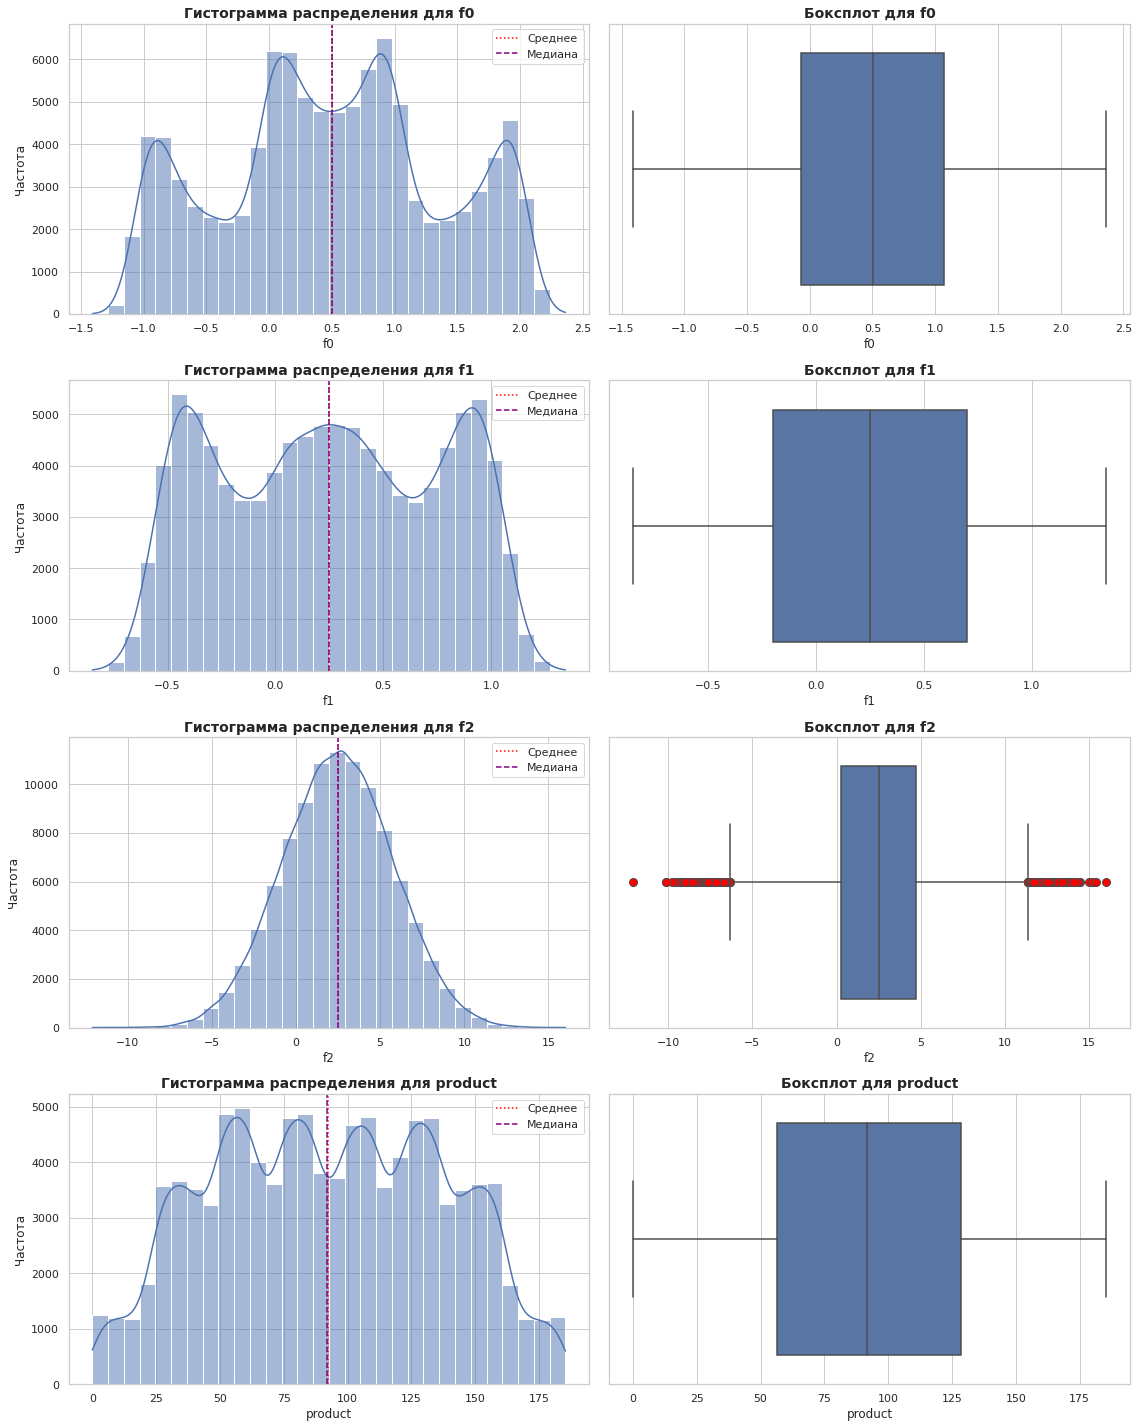

In [24]:
plot_h_bp(region_0, numeric_columns, 30)

**Region_1**

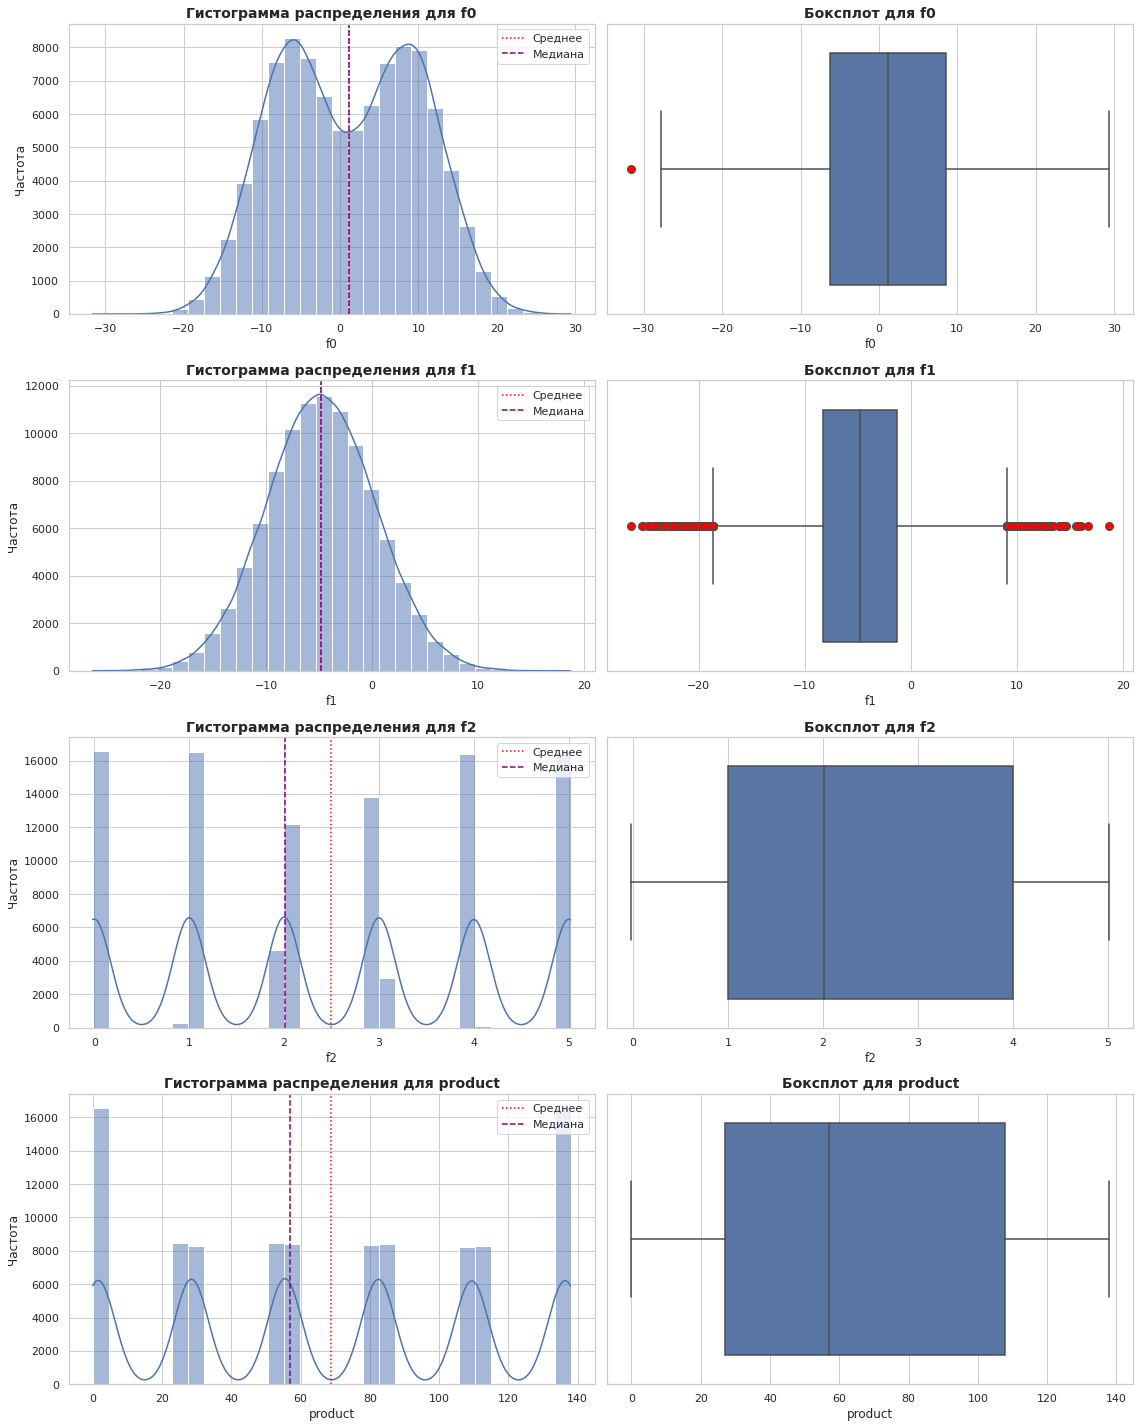

In [25]:
plot_h_bp(region_1, numeric_columns, 30)

**Region_2**

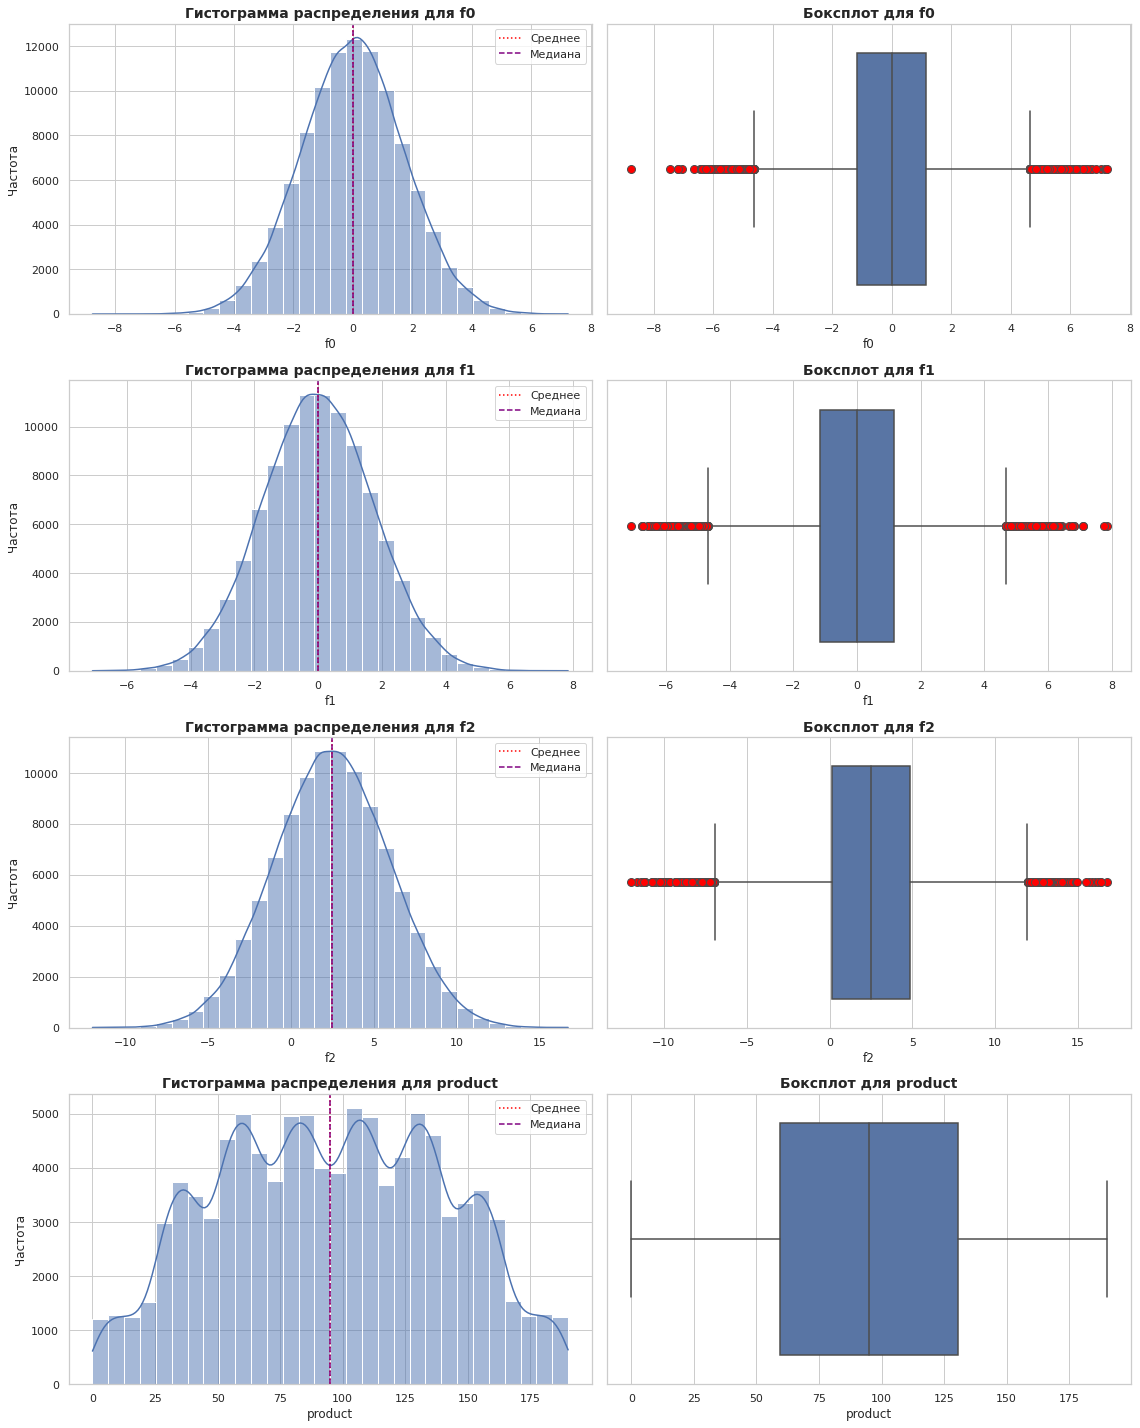

In [26]:
plot_h_bp(region_2, numeric_columns, 30)

Посмотрим значения медиана/среднее, min, max по всем признакам по всем DF 

In [27]:
for_in(dfs, describe_numeric_column)

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

f0: медиана/среднее= 0.5/0.5, min = -1.41, max = 2.36
f1: медиана/среднее= 0.25/0.25, min = -0.85, max = 1.34
f2: медиана/среднее= 2.52/2.5, min = -12.09, max = 16.0
product: медиана/среднее= 91.85/92.5, min = 0.0, max = 185.36


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

f0: медиана/среднее= 1.15/1.14, min = -31.61, max = 29.42
f1: медиана/среднее= -4.81/-4.8, min = -26.36, max = 18.73
f2: медиана/среднее= 2.01/2.49, min = -0.02, max = 5.02
product: медиана/среднее= 57.09/68.83, min = 0.0, max = 137.95


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

f0: медиана/среднее= 0.01/0.0, min = -8.76, max = 7.24
f1: медиана/среднее= -0.01/-0.0, min = -7.08, max = 7.84
f2: медиана/среднее= 2.48/2.5, min = -11.97, max = 16.74
product: медиана/среднее= 94.93/95.0, min = 0.0, max = 190.03


Проверим всем признаки на нормальное распределени

In [28]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    for column in numeric_columns:
        stat, p = shapiro(df[column])
        print(f'{column}, Statistic: {stat:.3f}, p-value: {p:.3f}')
        if p > 0.05:
            print('Вероятно, нормальное распределение\n')
        else:
            print('Вероятно, не нормальное распределение\n')

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

f0, Statistic: 0.972, p-value: 0.000
Вероятно, не нормальное распределение

f1, Statistic: 0.957, p-value: 0.000
Вероятно, не нормальное распределение

f2, Statistic: 1.000, p-value: 0.000
Вероятно, не нормальное распределение

product, Statistic: 0.979, p-value: 0.000
Вероятно, не нормальное распределение



/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

f0, Statistic: 0.978, p-value: 0.000
Вероятно, не нормальное распределение

f1, Statistic: 1.000, p-value: 0.304
Вероятно, нормальное распределение

f2, Statistic: 0.908, p-value: 0.000
Вероятно, не нормальное распределение

product, Statistic: 0.919, p-value: 0.000
Вероятно, не нормальное распределение



<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

f0, Statistic: 1.000, p-value: 0.642
Вероятно, нормальное распределение

f1, Statistic: 1.000, p-value: 0.990
Вероятно, нормальное распределение

f2, Statistic: 1.000, p-value: 0.004
Вероятно, не нормальное распределение

product, Statistic: 0.983, p-value: 0.000
Вероятно, не нормальное распределение



Построим ProbPlot

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

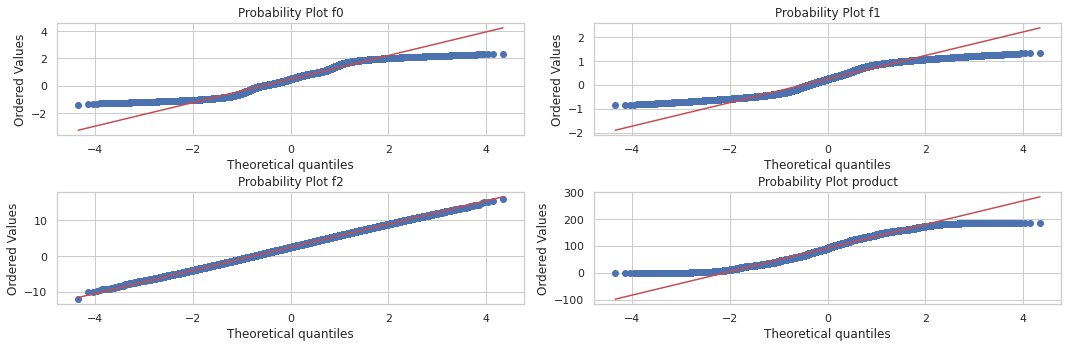

<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

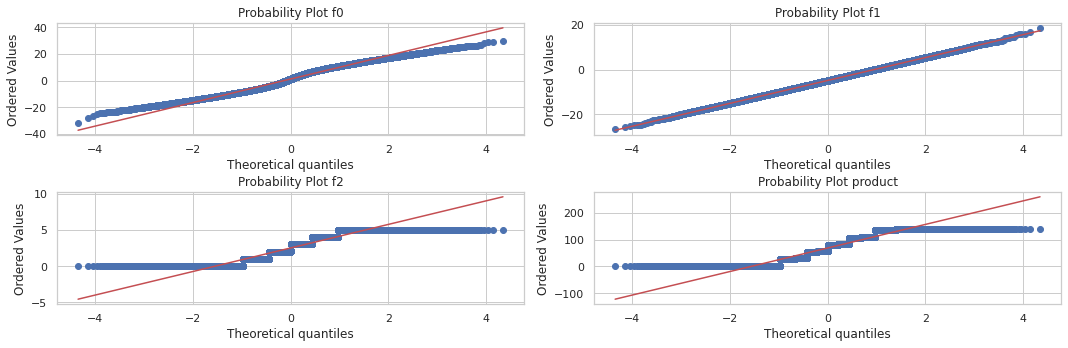

<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

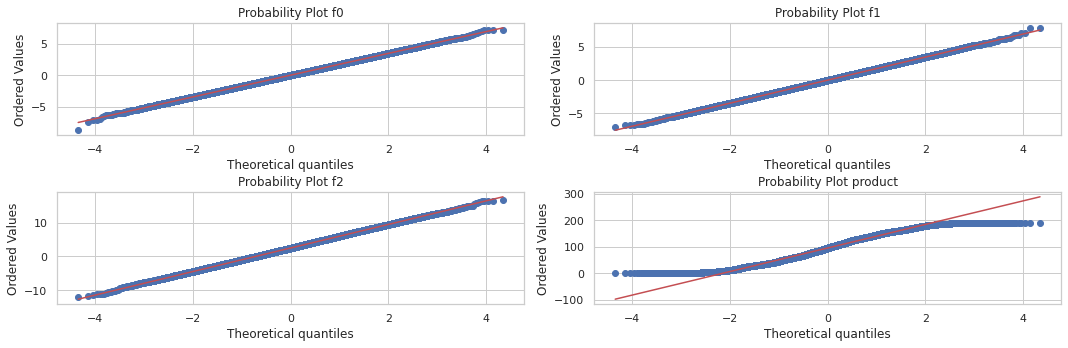

In [29]:
for_in(dfs, probplot)

#### Вывод

Во всех  регионах есть выбросы. Выбросы в данных не могут быть объяснены из-за отсутствия информации о признаках и допустимых значениях. Несмотря на это, объем выбросов невелик, поэтому их влияние на метрики модели, вероятно, несущественно. Оставляем выбросы в данных.

##### Region_0

- целевой признак **product**:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 91.85/92.5, min = 0.0, max = 185.36


- f0: 
    - Вероятно, не нормальное распределение
    - медиана/среднее= 0.5/0.5, min = -1.41, max = 2.36
    

- f1: 
    - Вероятно,  не нормальное распределение
    - медиана/среднее= 0.25/0.25, min = -0.85, max = 1.34
    
- f2:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 2.52/2.5, min = -12.09, max = 16.0


##### Region_1


- целевой признак **product**:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 57.09/68.83, min = 0.0, max = 137.95


- f0: 
    - Вероятно, нормальное распределение
    - медиана/среднее= 1.15/1.14, min = -31.61, max = 29.42

- f1: 
    - Вероятно, нормальное распределение
    - медиана/среднее= -4.81/-4.8, min = -26.36, max = 18.73
    
- f2:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 2.01/2.49, min = -0.02, max = 5.02


##### Region_2

- целевой признак **product**:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 94.93/95.0, min = 0.0, max = 190.03


- f0: 
    - Вероятно, не нормальное распределение
    - медиана/среднее= 0.01/0.0, min = -8.76, max = 7.24

- f1: 
    - Вероятно, нормальное распределение
    - медиана/среднее= -0.01/-0.0, min = -7.08, max = 7.84
    
- f2:
    - Вероятно, не нормальное распределение
    - медиана/среднее= 2.48/2.5, min = -11.97, max = 16.74

### Корреляционный анализ

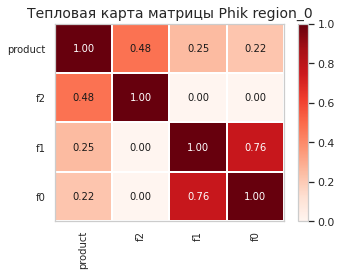

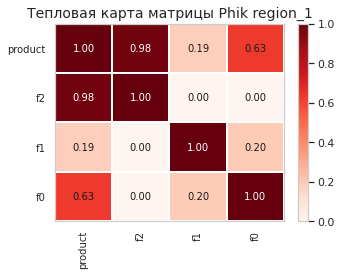

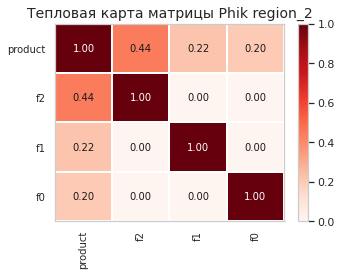

In [30]:
for name, df in dfs.items():
    phik_matrix_heatmap(df, numeric_columns)

расcчетаем VIF

In [31]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    vif_calculation(df)

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

,Feature,VIF
0,const,6.861281
1,f0,1.248703
2,f1,1.276589
3,f2,1.323671
4,product,1.380659


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

,Feature,VIF
0,const,7.561536
1,f0,3.163234
2,f1,1.049803
3,f2,2660.141618
4,product,2662.652617


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

,Feature,VIF
0,const,5.571816
1,f0,1.000004
2,f1,1.000003
3,f2,1.248132
4,product,1.248137


#### Вывод


- Region_0 и Region_2 - схожая картина
    - Мультиколлинеарность отсутствует
    - F2 обладает самой высокой корреляцией 0.48 и 0.44 соответственно
    
    
- Region_1
    - Мультиколлинеарность присутствует
    - F2 коэффицент корреляции 0.98
   
данные в этом проекте синтетические. Поэтому удивляться таким штукам не стоит в этом случае.
Возможно, это реальная специфика конкретного объекта, а может быть ошибки в данных. 
Из-за недостатка информации мы не можем принимать решение об удаление признака.

## Обучение и проверка модели


In [32]:
num_cols = ['f0', 'f1', 'f2']

In [33]:
def lin_regr_model(lin_reg_df, num_cols, target):
        
    all_cols = num_cols + [target]
    
    # создаём отдельный df
    model_lin_reg = lin_reg_df[all_cols].copy(deep=True)
    print('Проверка признаков для использования в модели:')
    print(model_lin_reg.columns)
    display(model_lin_reg.head(1))
    
    # разделяем X и y
    X = model_lin_reg.drop(target, axis=1)
    y = model_lin_reg[target]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = TEST_SIZE, 
                                                        random_state=RANDOM_STATE)
    
    # масштабируем
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # обучаем модель
    model_lr  = LinearRegression(n_jobs=-1)
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
        
    # считаем метрики
    residuals = y_test - predictions
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    print(f'R2 LinearRegression = {r2:.3f}')  
#     print(f'MAE LinearRegression = {mae:.0f}')
#     print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    
    # строим графики
    plt.figure(figsize=(6, 6))
    plt.scatter(predictions, y_test)
    plt.xlabel('Прогнозные значения модели')
    plt.ylabel('Реальные значения')
    plt.title('Диаграмма рассеяния прогнозных и реальных значений модели')
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
    axes[0].hist(residuals, bins=20)
    axes[0].axvline(residuals.mean(), color='r', linestyle='--', label='Смещенное \n среднее \n остатков')
    axes[0].legend(loc='upper left')
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals, alpha=0.3)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    
    # считаем средние значения: истинные и предсказанные
    true_mean = np.mean(y_test)
    predicted_mean= np.mean(predictions)
    # считаем медианные значения: истинные и предсказанные
    true_median = np.median(y_test)
    predicted_median = np.median(predictions)
    
    
    # словарь метрик
    metrics = {
        'r2': r2,
#         'mae': mae,
#         'mse': mse,
        'rmse': rmse
        }
    
    # словарь значений
    values = {
        'predictions': predictions,
        'residuals': residuals,
        'true_mean': true_mean,
        'predicted_mean': predicted_mean,
        'true_median': true_median,
        'predicted_median': predicted_median
    }
    
    # сохраним в таблицу истинные и предсказанные значения целевого признака
    true_pred_df = y_test.to_frame()
    true_pred_df['predicted_product'] = predictions
    true_pred_df.rename(columns={'product': 'true_product'}, inplace=True)
    
    return model_lr, metrics, values, scaler, true_pred_df

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

Проверка признаков для использования в модели:
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.22117,105.280062


R2 LinearRegression = 0.273
RMSE: 37.757


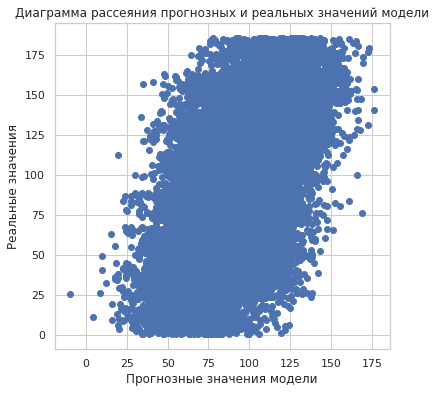

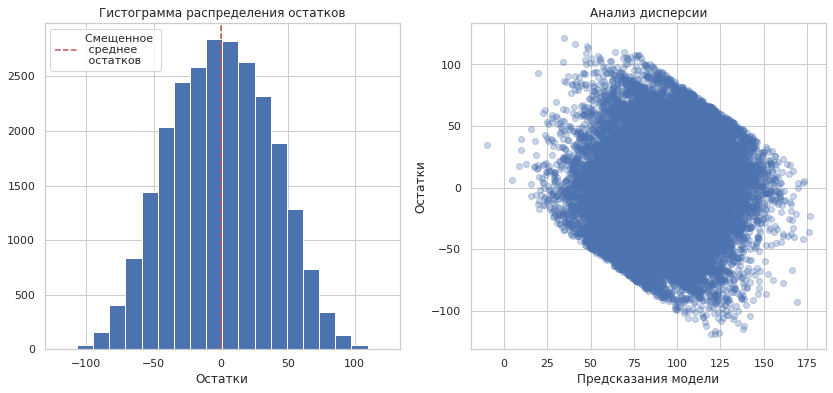

<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

Проверка признаков для использования в модели:
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276,-0.005876,3.179103


R2 LinearRegression = 1.000
RMSE: 0.890


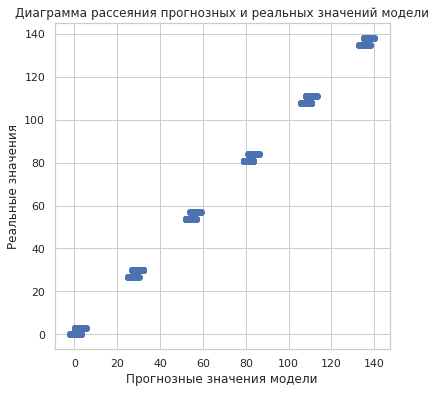

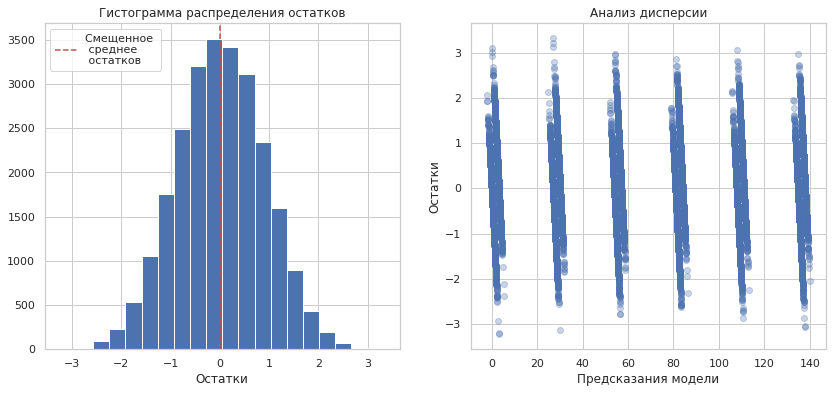

<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

Проверка признаков для использования в модели:
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673


R2 LinearRegression = 0.196
RMSE: 40.146


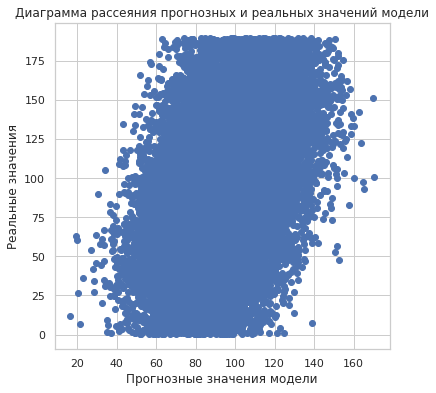

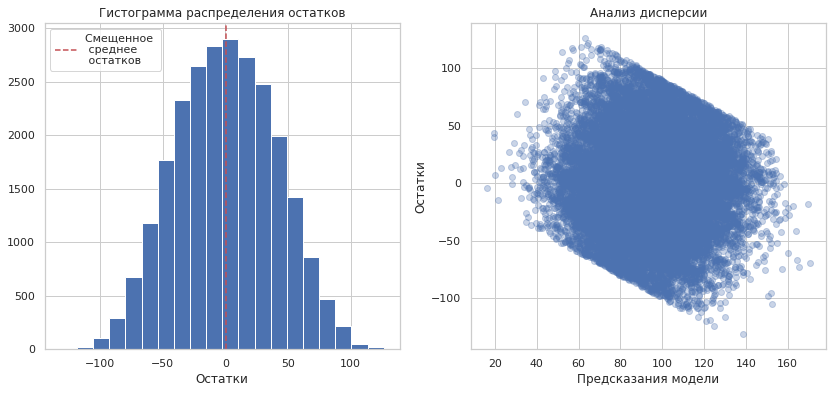

In [34]:
results_df = pd.DataFrame(columns=['DataFrame', 'R2', 'RMSE'])

for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    lin_model, metrics, values, scaler, true_pred_df = lin_regr_model(df, num_cols, 'product')
    
    results_df = results_df.append({
        'DataFrame': name,
        'R2': metrics['r2'],
#         'MAE': metrics['mae'],
        'RMSE': metrics['rmse'],
        'true_mean': values['true_mean'],
        'predicted_mean': values['predicted_mean'], 
        'true_median': values['true_median'],  
        'predicted_median': values['predicted_median']
    }, ignore_index=True)
        
    globals()[f'true_pred_{name}'] = true_pred_df
#     results_df = pd.DataFrame(columns=['DataFrame', 'R2', 'MAE', 'RMSE'])
#     true_pred_dfs[f'true_pred_df_{name}'] = true_pred_df    # Добавление результатов в DataFrame

Распечатем размер новых таблиц с истинными и предсказанными значениями по каждому региону и 3 первых строки



In [35]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    size = globals()[f'true_pred_{name}'].shape
    print(f"Размер дата фрейма: {size}")
    display(globals()[f'true_pred_{name}'].head(3))

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

Размер дата фрейма: (25000, 2)


,true_product,predicted_product
id,,
7C6bA,122.073350,101.901017
dVxsn,48.738540,78.217774
1Gm3l,131.338088,115.266901


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

Размер дата фрейма: (25000, 2)


,true_product,predicted_product
id,,
fYVDK,0.000000,0.844738
3SQcq,53.906522,52.921612
hQ1gJ,134.766305,135.110385


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

Размер дата фрейма: (25000, 2)


,true_product,predicted_product
id,,
sPjbT,117.441301,98.301916
1u4uo,47.841249,101.592461
kZ6HO,45.883483,52.449099


таблица с метриками и средними и медианными значенимями истинного и предсказаного

In [36]:
display(results_df)

,DataFrame,R2,RMSE,predicted_mean,predicted_median,true_mean,true_median
0,region_0,0.272829,37.756600,92.398800,92.414871,92.325956,90.785176
1,region_1,0.999625,0.890280,68.712878,57.918041,68.725381,57.085625
2,region_2,0.196347,40.145872,94.771024,94.612618,95.150999,94.936982


#### Вывод


Region_0 и Region_2 точность модели - низкая, ошибки модели очень высокие.

Region_1 точность модели - очень высокая, ошибки модели очень низкие.

- **region_0** 
    - R2 - 0.27, 
    - RMSE - 31.04
    
    
- **region_1**  
    - R2 - 0.99, 
    - RMSE - 0.89
    
    
- **region_2**  
    - R2 - 0.19, 
    - RMSE - 40.14

## Подготовка к расчёту прибыли

In [37]:
BUDGET = 10_000_000_000         

# число скважин в регионе
WELLS_REGION = 200     

# доход в руб за 1ед продукта (1000 баррелей)
REVENUE_PROD = 450_000          

Для определения безубыточной добычи со скважины в регионе мы:

- Делим бюджет на количество скважин в регионе, чтобы узнать бюджет на одну скважину.
- Затем этот результат делим на дохож с единицы продукты, чтобы выяснить необходимое количество добычи для безубыточной работы скважины.

In [38]:
break_even_point = BUDGET / WELLS_REGION / REVENUE_PROD
print(f'Точка безубыточности скважины {break_even_point:.2f} тыс. баррелей ')

Точка безубыточности скважины 111.11 тыс. баррелей 


In [39]:
results_df['break_even_point'] = break_even_point
display(results_df[['predicted_mean', 'break_even_point']])

,predicted_mean,break_even_point
0,92.398800,111.111111
1,68.712878,111.111111
2,94.771024,111.111111


Вывод: Как показали расчеты, по регионам в средний показатель добычи ниже точки безубыточности



In [40]:
def calculate_expected_revenue(true_pred_df, wells, revenue_threshold):
    filtered_df = true_pred_df.query(f"predicted_product > {revenue_threshold}")
    percent_greater_than_threshold = (len(filtered_df) / len(true_pred_df)) * 100

    return percent_greater_than_threshold

for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    expected_revenue = calculate_expected_revenue(globals()[f'true_pred_{name}'], 
                                                  WELLS_REGION, 
                                                  111.11111)
    
    print(f"{expected_revenue:.2f}% скважин превышают точку безубыточности")

    

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

21.03% скважин превышают точку безубыточности


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

18.08% скважин превышают точку безубыточности


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

20.96% скважин превышают точку безубыточности


Не все так плохо.

Составим функцию подсчета прибыли

In [41]:
def profit(true_pred_df, wells, revenue):
    sorted_df = true_pred_df.sort_values(by='predicted_product', 
                                         ascending= False)[:wells]    

    return (sorted_df.true_product.sum() * revenue - BUDGET) / 10**9    

In [42]:
for name, df in dfs.items():
    heading_violet(f'-------- {name} -------')
    expected_revenue = profit(globals()[f'true_pred_{name}'], WELLS_REGION, REVENUE_PROD)
    print(f'Ожидаемая прибыль с 200 лучших скважин по {name} составляет\
 {expected_revenue:.2f} млрд. рублей')

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

Ожидаемая прибыль с 200 лучших скважин по region_0 составляет 3.36 млрд. рублей


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

Ожидаемая прибыль с 200 лучших скважин по region_1 составляет 2.42 млрд. рублей


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

Ожидаемая прибыль с 200 лучших скважин по region_2 составляет 2.60 млрд. рублей


## Расчёт прибыли и рисков 

In [43]:
 def calculation_risks(true_pred_df, wells, revenue, number_wells_start):
    profits = []
    STATE = np.random.RandomState(12345) 
    
    for i in range(1000):
        sampled_df = true_pred_df.sample(n=number_wells_start, replace=True, random_state=STATE)
        sampled_profits = profit(sampled_df, wells, revenue)
        profits.append(sampled_profits)
        
    profits = pd.Series(profits)
        
    mean_profits = round(profits.mean(), 4)

    risk = round(((profits < 0).mean() * 100), 2)  

    lower_bound = round(profits.quantile(0.025), 3)
    upper_bound = round(profits.quantile(0.975), 3)
    confidence_interval = st.t.interval(0.95, len(profits)-1, profits.mean(), profits.sem())

    
    result = {
        'mean_profits': mean_profits,
        'risk': risk,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'confidence_interval': confidence_interval
    }
    
    return result, profits

<span style="color:MediumVioletRed;"><strong>-------- region_0 -------</span>

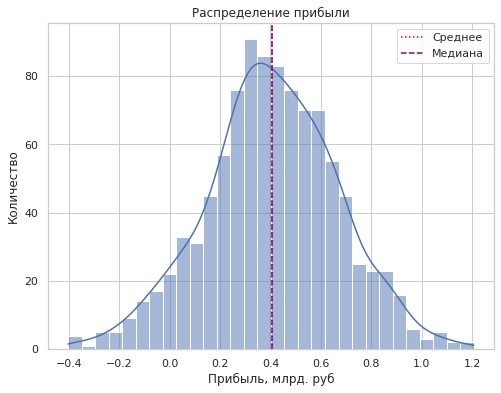

Средняя прибыль: 0.4063 млрд.руб
С вероятностью 95% прибыль в данном регионе будет от: -0.118 млрд.руб до:0.912 млрд.руб
95%-ый доверительный интервал для среднего значения прибыли: от 0.390 млрд.рубдо 0.423 млрд.руб
Процент вероятности убытка в данном регионе составит 6.7%


<span style="color:MediumVioletRed;"><strong>-------- region_1 -------</span>

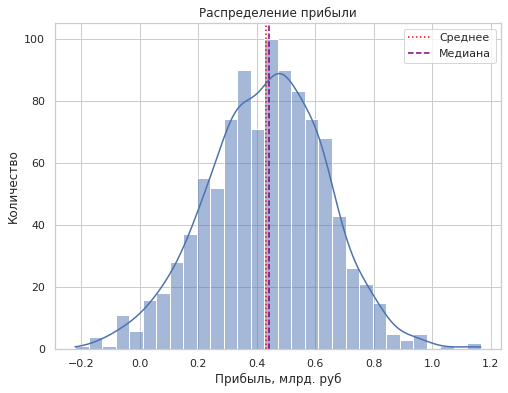

Средняя прибыль: 0.4326 млрд.руб
С вероятностью 95% прибыль в данном регионе будет от: 0.017 млрд.руб до:0.816 млрд.руб
95%-ый доверительный интервал для среднего значения прибыли: от 0.420 млрд.рубдо 0.445 млрд.руб
Процент вероятности убытка в данном регионе составит 1.9%


<span style="color:MediumVioletRed;"><strong>-------- region_2 -------</span>

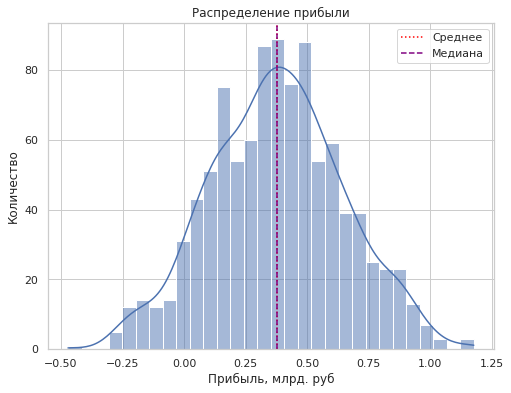

Средняя прибыль: 0.3774 млрд.руб
С вероятностью 95% прибыль в данном регионе будет от: -0.171 млрд.руб до:0.902 млрд.руб
95%-ый доверительный интервал для среднего значения прибыли: от 0.361 млрд.рубдо 0.394 млрд.руб
Процент вероятности убытка в данном регионе составит 7.4%


In [44]:
regions_result = pd.DataFrame()

for name, df in dfs.items():
    
    data_risk, profits = calculation_risks(globals()[f'true_pred_{name}'], 
                                           WELLS_REGION, 
                                           REVENUE_PROD, 
                                           500)  

    temp = pd.DataFrame([data_risk], index=[name])

    regions_result = pd.concat([regions_result, temp])
    regions_result = regions_result.drop('confidence_interval', axis=1)
    
    heading_violet(f'-------- {name} -------')
    plt.figure(figsize=(8, 6))
    sns.histplot(profits, bins=30, kde=True)
    plt.axvline(profits.mean(), color='red', linestyle=':', label='Среднее')
    plt.axvline(profits.median(), color='purple', linestyle='--', label='Медиана')
    plt.xlabel('Прибыль, млрд. руб')
    plt.ylabel('Количество')
    plt.legend()
    plt.title('Распределение прибыли')
    plt.show()
      
    print('Средняя прибыль: {} млрд.руб'.format(data_risk['mean_profits']))
    print('С вероятностью 95% прибыль в данном регионе будет от: {} млрд.руб до:\
{} млрд.руб'.format(data_risk['lower_bound'], data_risk['upper_bound']))
    
    confidence_interval = data_risk['confidence_interval']
    lower_bound = round(confidence_interval[0], 3) 
    upper_bound = round(confidence_interval[1], 3)

    print("95%-ый доверительный интервал для среднего значения прибыли: от {:.3f} млрд.руб\
до {:.3f} млрд.руб".format(lower_bound, upper_bound))        

    print ('Процент вероятности убытка в данном регионе составит {}%'.format(data_risk['risk']))
    


In [45]:
regions_result

,mean_profits,risk,lower_bound,upper_bound
region_0,0.4063,6.7,-0.118,0.912
region_1,0.4326,1.9,0.017,0.816
region_2,0.3774,7.4,-0.171,0.902


### Вывод


По условию задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. 

Region_1 с риском 1.9% является приоритетным для разработки буровых скважин.

Если появятся дополнительные признаки то можно до исследовать Region_0 (он демонстрирует наивысшую ожидаемую прибыль с лучших 200 скважин, однако уровень риска составляет 6.7%)

Region_2 - занимает 3 место


## Общий вывод

### Загрузка и подготовка данных

**Загрузка данных**



- загрузили 3 дата фрэйма
- данные соответствуют описанию
- типы данных соответствуют содержимому
- явных дубликатов нет 
- явных пропусков нет
- в каждом дата фрэйме по 100000 строк и 5 столбцов


**Предобработка данных**

- выявили дубликаты по id, оставили без изменений
- id сделали индексами
- проверка полных дубликатов без id по всем DF показала что нет дубликатов

**Иследовательский анализ**

Во всех  регионах есть выбросы. Выбросы в данных не могут быть объяснены из-за отсутствия информации о признаках и допустимых значениях. Несмотря на это, объем выбросов невелик, поэтому их влияние на метрики модели, вероятно, несущественно. Оставляем выбросы в данных.

**целевой признак product**:

- Region_0 - медиана/среднее= 91.85/92.5, min = 0.0, max = 185.36
- Region_1 - медиана/среднее= 57.09/68.83, min = 0.0, max = 137.95
- Region_2 - медиана/среднее= 94.93/95.0, min = 0.0, max = 190.03

**Корреляционный анализ**

- Region_0 и Region_2 - схожая картина
    - Мультиколлинеарность отсутствует
    - F2 обладает самой высокой корреляцией 0.48 и 0.44 соответственно
    
    
- Region_1
    - Мультиколлинеарность присутствует
    - F2 коэффицент корреляции 0.98
   
данные в этом проекте синтетические. Поэтому удивляться таким штукам не стоит в этом случае.
Возможно, это реальная специфика конкретного объекта, а может быть ошибки в данных. 
Из-за недостатка информации мы не можем принимать решение об удаление признака.

### Обучение и проверка модели


Region_0 и Region_2 точность модели - низкая, ошибки модели очень высокие.

Region_1 точность модели - очень высокая, ошибки модели очень низкие.

- **region_0** 
    - R2 - 0.27, 
    - RMSE - 31.04
    
    
- **region_1**  
    - R2 - 0.99, 
    - RMSE - 0.89
    
    
- **region_2**  
    - R2 - 0.19, 
    - RMSE - 40.14

### Подготовка к расчёту прибыли

**Точка безубыточности скважины 111.11 тыс. баррелей**

**region_0**
- средний показатель добычи 92.39 ниже точки безубыточности
- 21.03% скважин превышают точку безубыточности
- Ожидаемая прибыль с 200 лучших скважин по region_0 составляет 3.36 млрд. рублей

**region_1**
- средний показатель добычи 68.71 ниже точки безубыточности
- 18.08% скважин превышают точку безубыточности
- Ожидаемая прибыль с 200 лучших скважин по region_1 составляет 2.42 млрд. рублей

**region_2**
- средний показатель добычи 94.77 ниже точки безубыточности
- 20.96% скважин превышают точку безубыточности
- Ожидаемая прибыль с 200 лучших скважин по region_2 составляет 2.60 млрд. рублей

### Расчёт прибыли и рисков

In [46]:
regions_result

,mean_profits,risk,lower_bound,upper_bound
region_0,0.4063,6.7,-0.118,0.912
region_1,0.4326,1.9,0.017,0.816
region_2,0.3774,7.4,-0.171,0.902


По условию задачи после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Region_1** с риском 1.9% является приоритетным для разработки буровых скважин.

Если появятся дополнительные признаки то можно до исследовать **Region_0** (он демонстрирует наивысшую ожидаемую прибыль с лучших 200 скважин, однако уровень риска составляет 6.7%)

**Region_2** - занимает 3 место